In [2]:
from endolas import utils
import json
import numpy as np
import scipy.io
from pdb import set_trace

# Loads data from keypoints and calibration and carries out reconstruction

Create a matlab like formed data structure

In [3]:
with open('roi_2_mat/KK17_gap0_Cam_16904_Cine2_0_19.rois') as json_file:
    data = json.load(json_file)
    
np_data = np.zeros((18,18,2,20))

for frame_index, frame in enumerate(data['frames']):
    for roi_index,roi in enumerate(frame['roi_positions']):
        i_w = roi_index % 18
        i_h = roi_index // 18
        
        np_data[i_h][i_w][0][frame_index] = roi['pos']['x']
        np_data[i_h][i_w][1][frame_index] = roi['pos']['y']
        
np_data = np_data[4:17,:,:,:]
np_data = np.flip(np_data, 0)
np_data = np.where(np_data==-1, np.nan, np_data)

In [6]:
np_data.shape

(13, 18, 2, 20)

Load the calibration file

In [4]:
calibration = scipy.io.loadmat('roi_2_mat/KK17_experiment_18.mat')

Carry out calibration

In [5]:
def get_laser_grid(alpha, n_rows, n_cols, xy_offset):
    laser_grid = np.zeros((3, n_rows*n_cols))

    middle_index = xy_offset.size//2
    end_index = xy_offset.size
    x_offset = xy_offset[0:middle_index]
    y_offset = xy_offset[middle_index:end_index]
    
    grid_index = 0
    for row_index in range(n_rows):
        for col_index in range(n_cols):
            laser_grid[0][grid_index] = np.tan((col_index - ((n_cols-1)/2)) * alpha[0]) + x_offset[grid_index][0]
            laser_grid[1][grid_index] = np.tan((row_index - ((n_rows-1)/2)) * alpha[0]) + y_offset[grid_index][0]
            laser_grid[2][grid_index] = 1.0
            grid_index +=1
        
    return laser_grid

In [6]:
def extract_laser_grid(laser_grid, n_rows, n_cols, n_rows_present, n_cols_present,
                       row_offset=0, col_offset=0):
    laser_grid = laser_grid.reshape(3, n_rows, n_cols)
    laser_grid = laser_grid[:,row_offset:n_rows_present,col_offset:n_cols_present]
    laser_grid = laser_grid.reshape(3, n_rows_present * n_cols_present)
    
    return laser_grid

In [7]:
def eldot(a,b):
    return np.sum(a * b, axis=0)

In [8]:
def reconstruct(laser_points, camera_points, R, t):
    alpha = np.dot(-R, laser_points)
    t = np.repeat(t, alpha.shape[1], axis=1)
    numerator = eldot(alpha, alpha) * eldot(camera_points, t) - eldot(alpha, camera_points) * eldot(alpha,t)
    denominator = eldot(alpha, alpha) * eldot(camera_points, camera_points) - eldot(alpha, camera_points)**2
    
    denominator = np.where(denominator==0.0, np.nan, denominator)
    
    z_camera = numerator / denominator
    camera_points = z_camera * camera_points
    
    return camera_points

In [9]:
def reconstruct_film(points, calibration):
    # extract parameters from calibration
    camera_calibration = dict()
    camera_calibration['fc'] = calibration['cam'][0][0][0]
    camera_calibration['cc'] = calibration['cam'][0][0][1]
    camera_calibration['alpha_c'] = calibration['cam'][0][0][2]
    camera_calibration['kc'] = calibration['cam'][0][0][3]
    camera_calibration['A'] = calibration['cam'][0][0][4]
    
    laser_calibration = dict()
    laser_calibration['r'] = calibration['lsr'][0][0][0]
    laser_calibration['t'] = calibration['lsr'][0][0][1]
    laser_calibration['alpha'] = calibration['lsr'][0][0][2]
    laser_calibration['err'] = calibration['lsr'][0][0][3]
    laser_calibration['R'] = calibration['lsr'][0][0][4]
    laser_calibration['Lambda'] = calibration['lsr'][0][0][5]
    laser_calibration['lsrArrayDims'] = calibration['lsr'][0][0][6]
    
    # parameters
    width = 768
    n_rows = 18
    n_cols = 18
    
    # prepare the data structure
    n_rows_present = points.shape[0]
    n_cols_present = points.shape[1]
    frames = points.shape[3]
    
    # get the laser grid
    laser_grid = get_laser_grid(laser_calibration['alpha'], n_rows, n_cols, laser_calibration['Lambda'])
    
    # select only present rows and cols
    laser_grid = extract_laser_grid(laser_grid, n_rows, n_cols, n_rows_present, n_cols_present)
    
    A = camera_calibration['A']
    R = laser_calibration['R']
    t = laser_calibration['t']
    kc = camera_calibration['kc']
    
    data = list()
    # loop over frames
    for frame_index in range(frames):
        U = points[:, :, 0, frame_index]
        V = points[:, :, 1, frame_index]
        
        u = U.reshape(n_rows_present*n_cols_present)
        v = V.reshape(n_rows_present*n_cols_present)
        
        # assign values to homogeneous coordinates, w=0 for not existing values
        u_vec = np.zeros((3, n_rows_present*n_cols_present))
        for grid_index in range(n_rows_present*n_cols_present):
            u_vec[0,grid_index] = u[grid_index] if not np.isnan(u[grid_index]) else 0.0
            u_vec[1,grid_index] = v[grid_index] if not np.isnan(u[grid_index]) else 0.0
            u_vec[2,grid_index] = 1.0 if not np.isnan(u[grid_index]) else 0.0
        
        
        # solve system of equations to find projected coordinates
        x_vec = np.linalg.lstsq(A, u_vec)[0]

        # undistort
        r2 = x_vec[0,:]**2 + x_vec[1,:]**2
        r4 = r2**2
        r6 = r2**3
        rd = 1 + kc[0][0] * r2 + kc[1][0] * r4 + kc[4][0] * r6
        x_vec_d = x_vec[0:2,:] * rd
        
        a1 = 2 * x_vec[0,:] * x_vec[1,:] 
        a2 = r2 + 2 * x_vec[0,:] ** 2
        a3 = r2 + 2 * x_vec[1,:] ** 2
        
        delta_x_1 = kc[2] * a1 + kc[3] * a2
        delta_x_2 = kc[2] * a3 + kc[3] * a1
        
        delta_x = np.array([delta_x_1, delta_x_2])
        
        x_vec_d = x_vec_d + delta_x
        x_vec_d = np.append(x_vec_d, np.array([x_vec[2,:]]), 0)
        
        # triangulated
        data.append(reconstruct(laser_grid, x_vec_d, R, t))
        
        
    return data

In [10]:
data = reconstruct_film(np_data, calibration)

<ipython-input-9-3c39c1f1fa92>:58: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_vec = np.linalg.lstsq(A, u_vec)[0]


In [11]:
data[0][:,100]

array([ -0.94914541,  -8.36454972, 686.90780909])

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


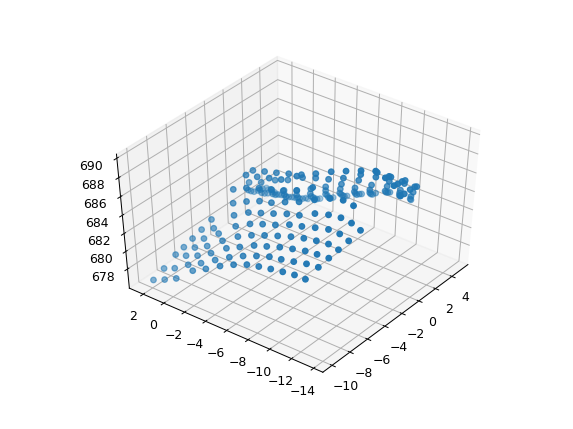

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0][0,:], data[0][1,:], data[0][2,:])